In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import logging
import jax
import jax.numpy as jnp

os.chdir("/Users/mark/Code/luas")

import pymc as pm
import arviz as az
import corner

from src.luas.GPyMCClass import GPyMC
from src.luas.sample_kernels import build_VLT_kernel, build_VLT_GeneralKernel
from src.luas.transit_functions import transit_2D, ld_to_kipping, transit_param_transform
from src.luas.kronecker_functions import *

logging.getLogger().setLevel(logging.INFO)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
NUTS_step.name

'nuts'

In [60]:
from pymc.step_methods import CompoundStep

# Generate some synthetic data for linear regression
np.random.seed(0)
X = np.linspace(0, 10, 100)
true_slope = 2.0
true_intercept = 1.0
y = true_slope * X + true_intercept + np.random.normal(0, 1, size=len(X))

# Define the PyMC3 model
with pm.Model() as linear_model:
    # Define priors for the parameters
    slope = pm.Normal("slope", mu=0, sigma=10)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Define the likelihood
    sigma = pm.Exponential("sigma", 1.0)
    y_obs = pm.Normal("y_obs", mu=slope * X + intercept, sigma=sigma, observed=y)
    
    NUTS_step = pm.NUTS([slope, intercept])
    slice_step = pm.Slice([sigma])
    steps = CompoundStep([NUTS_step, slice_step])
    
    # Use the No-U-Turn Sampler (NUTS) for sampling
    trace = pm.sample(1000, tune=1000, cores=1, chains=1, step = steps)

INFO:pymc:Sequential sampling (1 chains in 1 job)
INFO:pymc:CompoundStep
INFO:pymc:>NUTS: [slope, intercept]
INFO:pymc:>Slice: [sigma]


INFO:pymc:Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


In [62]:
steps.current_step

'slice'

Load in data and pre-computed limb darkening coefficients

In [29]:
data_save_name = f"WASP31b_FORS2_600B"
data_folder = os.path.join("sample_data", data_save_name)

x_l = np.load(os.path.join(data_folder, f"x_l.npy"))
x_t = np.load(os.path.join(data_folder, f"x_t.npy"))
Y = np.load(os.path.join(data_folder, f"Y.npy"))
ld_coeff = np.load(os.path.join(data_folder, f"ld_coeff.npy"))
ld_coeff_errs = 0.01*np.ones((x_l.size, 2))

# Convert limb darkening coefficients to Kipping transformed parameters q1, q2
q1, q2 = ld_to_kipping(ld_coeff[:, 0], ld_coeff[:, 1])

N_l = x_l.size
N_t = x_t.size

x_l = jax.device_put(x_l)
x_t = jax.device_put(x_t)
Y = jax.device_put(Y)

Define initial parameters, kernel function, priors, parameters to fit for and then build GPyMC object

Note: Save location unspecified, defaulting to '/analyses/default_loc/122008_11_09_23_999'
Note: Filename suffix unspecified, defaulting to '174035'
Starting logL:  23206.061058463318


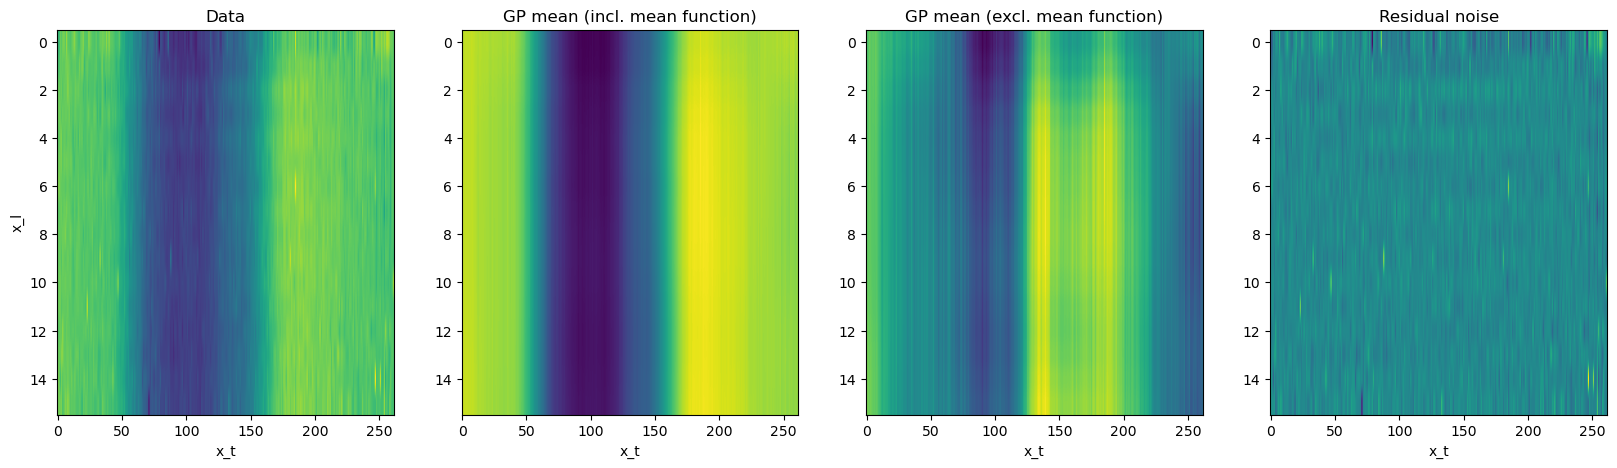

In [39]:
# Specify initial parameters to use as starting point for optimisation
initial_params = {"T0":-0.0021*np.ones(1), "P":3.4059095*np.ones(1), "a":8.19*np.ones(1), "b":0.761*np.ones(1), "rho_2":0.12546**2*np.ones(N_l),
                  "c1":q1, "c2":q2, "Foot":np.ones(N_l)*0.9995, "Tgrad":np.ones(N_l)*0.0002,
                  "h_CM":1.5e-3*np.ones(1), "l_t":0.011*np.ones(1), "l_l_CM":10000*np.ones(1), "sigma":1.2e-3*np.ones(N_l),
                  "h_WSS":2e-4*np.ones(N_l), "h_HFS":3e-4*np.ones(1), "l_l_HFS":1000*np.ones(1), "l_l_WSS":300.}

# Choose the kernel previously used for fitting VLT data (imported from sample_kernels)
# VLT_kernel = build_VLT_kernel()
VLT_kernel = build_VLT_kernel()

# Specify Gaussian priors on some parameters
prior_values = {"a":8.19, "b":0.761}
prior_std = {"a":0.1, "b":0.018}

prior_dict = {"a":[prior_values["a"], prior_std["a"]], "b":[prior_values["b"], prior_std["b"]],
              "c1":[ld_coeff[:, 0], ld_coeff_errs[:, 0]], "c2":[ld_coeff[:, 1], ld_coeff_errs[:, 1]]}


# Specify bounds on parameters for use with PyMC
param_bounds = {"T0":[np.array([-0.01]), np.array([0.01])],
                "rho_2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "sigma":[np.array([1e-5]*N_l), np.array([1e-2]*N_l)],
                "Foot":[np.array([0.99]*N_l), np.array([1.01]*N_l)],
                "Tgrad":[np.array([-0.1]*N_l), np.array([0.1]*N_l)],
                "c1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "c2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "h_WSS":[np.array([1e-6]*N_l), np.array([1e-2]*N_l)],
                "h_CM":[np.array([1e-6]*1), np.array([1e-2]*1)],
                "l_t":[np.array([np.diff(x_t).min()]), np.array([2*(x_t.max() - x_t.min())])],
                "l_l_CM":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])],
                "h_HFS":[np.array([1e-6]), np.array([1e-2])],
                "l_l_HFS":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])],
                "l_l_WSS":[np.array([np.diff(x_l).min()]), np.array([50*(x_l.max() - x_l.min())])]}

# Specify parameters to vary for inference
mfp_to_vary = ["T0", "a", "b", "c1", "c2", "rho_2", "Foot", "Tgrad"]         # Mean function parameters
hp_to_vary = ["h_CM", "l_l_CM", "l_t", "h_WSS", "h_HFS", "l_l_HFS", "sigma", "l_l_WSS"] # Hyperparameters

# Specify parameters to use log priors on
log_params = ["h_CM", "l_t", "l_l_CM", "sigma", "h_WSS", "h_HFS", "l_l_HFS", "l_l_WSS"]

# Convert starting values and parameter bounds to log values
for name in log_params:
    initial_params[name] = np.log10(initial_params[name])
    param_bounds[name][0] = np.log10(param_bounds[name][0])
    param_bounds[name][1] = np.log10(param_bounds[name][1])

    
# Define GP object
gp = GPyMC(initial_params, mfp_to_vary, hp_to_vary, x_l, x_t, Y, VLT_kernel,
       mf = transit_2D, log_params = log_params, transform_fn = transit_param_transform,
        gaussian_prior_dict = prior_dict, param_bounds = param_bounds)


print("Starting logL: ", gp.logL(gp.p))
gp.plot(gp.p)

In [37]:
gp.p_opt = gp.optimise()
# gp.Y = gp.clip_outliers(gp.p_opt, 4.)
# gp.p = gp.optimise()

In [38]:
gp.logP(gp.p_opt)

DeviceArray(24317.39997248, dtype=float64)

In [ ]:
grad_logL, storage_dict = gp.grad_logL(gp.p, storage_dict = {})
%timeit gp.grad_logL(gp.p, storage_dict = storage_dict)

In [ ]:
hess, storage_dict = gp.grad_logL(gp.p, storage_dict = {})

In [ ]:
p_dict = gp.make_p_dict(gp.p_arr)
gp.grad_logL(p_dict)

In [ ]:
p, p_is_array = gp.check_p_type(gp.p_arr)
hess, storage_dict = gp.grad_logL(p, storage_dict = {})
hess, storage_dict = gp.grad_logL(gp.p_arr, storage_dict = {})
#%timeit gp.hessian_logL(gp.p, storage_dict = {})

In [ ]:
p, p_type = gp.check_p_type(gp.p_arr)

In [ ]:
hess, storage_dict = gp.hessian_logL(p, storage_dict = {})

In [ ]:
logL, grad_logL, storage_dict = gp.value_and_grad_logL(gp.p, storage_dict = {})
%timeit gp.value_and_grad_logL(gp.p, storage_dict = storage_dict)

In [ ]:
logL, storage_dict = gp.logL(gp.p, storage_dict = {})
grad_logL, storage_dict = gp.grad_logL(gp.p, storage_dict = storage_dict)
logL, grad_logL

In [ ]:
logL2, storage_dict = gp.logL(gp.p, storage_dict = {})
grad_logL2, storage_dict = gp.grad_logL(gp.p, storage_dict = storage_dict)
logL2, grad_logL2

In [ ]:
23193.892714528636

In [ ]:
logL, eigen_dict = gp.logL(gp.p, eigen_dict = {})
%timeit gp.logL(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()

In [ ]:
logP, eigen_dict = gp.logP(gp.p, eigen_dict = {})
%timeit gp.logP(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()

In [ ]:
logP, eigen_dict = gp.logP(gp.p, eigen_dict = {})
%timeit gp.logL(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()
%timeit gp.logP(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()
%timeit gp.grad_logL(gp.p, eigen_dict = eigen_dict)[0]["rho_2"].block_until_ready()
%timeit gp.grad_logP(gp.p, eigen_dict = eigen_dict)[0]["rho_2"].block_until_ready()

In [ ]:
gp.logL(gp.p)
gp.grad_logL(gp.p)
%timeit gp.logL(gp.p).block_until_ready()
%timeit gp.logP(gp.p).block_until_ready()
%timeit gp.grad_logL(gp.p)["rho_2"].block_until_ready()
%timeit gp.grad_logP(gp.p)["rho_2"].block_until_ready()

In [ ]:
jnp.zeros((1, 2)).ndim

In [ ]:
eigen_dict = gp.eigen_fn_transf(gp.p, gp.x_l, gp.x_t)
gp.logL(gp.p, eigen_dict = eigen_dict)
%timeit gp.logL(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()

In [ ]:
def test(x, f):
    return f(x**2)

def f(x):
    if x > 1:
        return x
    else:
        return -x

test_jit = jax.jit(test, static_argnums=1)
test_jit(2., f)

In [ ]:
eigen_jit = jax.jit(gp.eigen_fn_transf)
eigen_dict = eigen_jit(gp.p, gp.x_l, gp.x_t, eigen_dict = {})
eigen_jit(gp.p, gp.x_l, gp.x_t, eigen_dict = eigen_dict)

# no_checks_jit = jax.jit(gp.kf.eigendecomp_no_checks_jittable)
# no_checks_jit(gp.transf_p(gp.p), gp.x_l, gp.x_t, eigen_dict = {})

# eigen_dict = deepcopy(gp.eigen_dict)
#eigen_dict["hp"]["l_t"][:].at[0].set(0.123512)

%timeit eigen_jit(gp.p, gp.x_l, gp.x_t, eigen_dict = {})
%timeit eigen_jit(gp.p, gp.x_l, gp.x_t, eigen_dict = eigen_dict)
%timeit no_checks_jit(gp.transf_p(gp.p), gp.x_l, gp.x_t, eigen_dict = {})

In [ ]:
gp.eigen_dict["hp"] = deepcopy(gp.transf_p(gp.p))
#gp.eigen_dict["hp"]["l_t"] = gp.eigen_dict["hp"]["l_t"].at[0].set(0.123512)

In [ ]:
logL_fast_transf = lambda p, *args, **kwargs: gp.kf.logL_fast(gp.transf_p(p), *args, **kwargs)
grad_logL_fast_transf = lambda p, *args, **kwargs: gp.kf.grad_logL_fast(gp.transf_p(p), *args, **kwargs)
value_and_grad_logL_fast = jax.value_and_grad(logL_fast_transf, has_aux = True)
hp_grad_logL_fast = jax.grad(grad_logL_fast_transf)

logL_fast_transf2 = lambda p, *args, **kwargs: gp.kf.logL_fast2(gp.transf_p(p), *args, **kwargs)
grad_logL_fast_transf2 = lambda p, *args, **kwargs: gp.kf.grad_logL_fast2(gp.transf_p(p), *args, **kwargs)
value_and_grad_logL_fast2 = jax.value_and_grad(logL_fast_transf2, has_aux = True)
hp_grad_logL_fast2 = jax.grad(grad_logL_fast_transf2)

In [ ]:
def fast_value_grad_eigen_logP(p, eigen_dict):
    logPrior = gp.logPrior_transf(p)

    # Calculate any necessary eigendecompositions
    eigen_dict = eigen_jit(p, gp.x_l, gp.x_t, eigen_dict = eigen_dict)
    
    prior_grad_dict = gp.grad_logPrior_transf(p)
    (logL, alpha2), grad_mfp = value_and_grad_logL_fast(p, gp.x_l, gp.x_t, gp.Y, eigen_dict, gp.mf)
    grad_hp = hp_grad_logL_fast(p, gp.x_l, gp.x_t, alpha2, eigen_dict)

    grad_dict = {k: prior_grad_dict[k]+grad_mfp[k] for k in gp.mfp}
    grad_dict.update({k: prior_grad_dict[k]+grad_hp[k] for k in gp.hp})

    return logPrior + logL, grad_dict, eigen_dict
l_jit = jax.jit(fast_value_grad_eigen_logP)
l_jit(gp.p, eigen_dict)

%timeit l_jit(gp.p, eigen_dict)[0].block_until_ready()

In [ ]:
type(gp.p)

In [ ]:
def fast_value_grad_eigen_logP(p, eigen_dict):
    logPrior = gp.logPrior_transf(p)

    # Calculate any necessary eigendecompositions
    eigen_dict = eigen_jit(p, gp.x_l, gp.x_t, eigen_dict = eigen_dict)
    
    prior_grad_dict = gp.grad_logPrior_transf(p)
    (logL, alpha), grad_mfp = value_and_grad_logL_fast2(p, gp.x_l, gp.x_t, gp.Y, eigen_dict, gp.mf)
    grad_hp = hp_grad_logL_fast2(p, gp.x_l, gp.x_t, alpha, eigen_dict)

    grad_dict = {k: prior_grad_dict[k]+grad_mfp[k] for k in gp.mfp}
    grad_dict.update({k: prior_grad_dict[k]+grad_hp[k] for k in gp.hp})

    return logPrior + logL, grad_dict, eigen_dict
l_jit = jax.jit(fast_value_grad_eigen_logP)
l_jit(gp.p, eigen_dict)

%timeit l_jit(gp.p, eigen_dict)[0].block_until_ready()

In [ ]:
j_jit = jax.jit(gp.value_and_grad_logP)
j_jit(gp.p, eigen_dict = eigen_dict)

%timeit j_jit(gp.p, eigen_dict = eigen_dict)[0].block_until_ready()

In [ ]:
logLvals[0][0]

Optimise, clip 4 sigma outliers and optimise again

In [ ]:
gp.p_opt = gp.optimise()
gp.Y = gp.clip_outliers(gp.p_opt, 4.)
gp.p = gp.optimise()

Save optimised GP state to avoid needing to rerun

In [ ]:
gp.save()
gp.logP(gp.p)

In [ ]:
gp_load = GPyMC_from_file("analyses/default_loc/135307_17_08_23_719", "GP_save_4682259.pkl", build_VLT_kernel(),
                mf = transit_2D, eigen_fn = eigendecomp_no_checks_jittable, jit_fn = True)
gp_load.logP(gp_load.p)

May want to change parameters being fit for in MCMC so redefine a new object here

In [ ]:
# New parameters to fit for
mfp_to_vary = ["T0", "c1", "c2", "a", "b", "rho_2", "Foot", "Tgrad"]
hp_to_vary = ["h_CM", "l_t", "h_HFS", "l_l_HFS", "sigma", "l_l_CM", "h_WSS"]

# Define optimised initial parameters including the fixed parameters which were not optimised
opt_params = deepcopy(initial_params)
opt_params.update(gp.p)

gp2 = GPyMC(opt_params, mfp_to_vary, hp_to_vary, x_l, x_t, gp.Y, VLT_kernel,
       log_params = log_params, eigen_fn = eigendecomp_no_checks_jittable,
        mf = transit_2D, gaussian_prior_dict = prior_dict, param_bounds = param_bounds) #eigendecomp_rakitsch_general) #eigendecomp_no_checks_jittable)

print(gp2.logP(gp2.p))

In [ ]:
gp2.cov_dict

In [ ]:
gp2.run_NUTS(tune = 1000, draws = 1000, chains = 2, slice_sample = [])

In [ ]:
df_summary_2D = gp2.summary()

In [ ]:
gp2.plot_corner(params = ["h_WSS"], dims = [3, 5, 12])

In [ ]:
gp2.save_folder

In [ ]:
gp2 = GPyMC_from_file("analyses/default_loc/135307_17_08_23_719", "GP_save_4682259.pkl", build_VLT_kernel(),
                mf = transit_2D, eigen_fn = eigendecomp_no_checks_jittable, jit_fn = True)

df_summary_2D = gp2.summary(show = False)
h_WSS_mask = df_summary_2D.loc[[f"h_WSS[{i}]" for i in range(N_l)], "ess_tail"].to_numpy() < 100

print(h_WSS_mask)

In [ ]:
gp3 = gp2.param_split(gp2.p, ["h_WSS"], [h_WSS_mask], eigen_fn = eigendecomp_Kl_checks_jittable, jit_fn = True)
gp3.logP(gp3.p)

In [ ]:
gp3.run_NUTS(tune = 1000, draws = 1000, chains = 2, slice_sample = ["h_WSS1"])